In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup path
project_root = os.path.abspath(r".") 
if project_root not in sys.path:
    sys.path.append(project_root)

# 2. Import Modules
# Math tools: Gauss, Jacobian, Newton
from functions.math_toolbox import Gauss, get_jacobian, Newton

# Physics: The equations of motion and the residual function 
from functions.physics import cr3bp_equations, lagrange_residual

# Temporal Schemes: ODE Solvers
import functions.temporal_schemes as schemes 

In [8]:
MU = 0.0121505856
print(f"{'POINT':<6} | {'LOCATION (x)':<15} | {'STABILITY CHECK'}")
print("-" * 45)

locations = {}
# 1. Solve Collinear (L1, L2, L3)
guesses = {"L1": [0.83], "L2": [1.15], "L3": [-1.00]}
for name, g in guesses.items():
    x_sol = Newton(lagrange_residual, g, mu=MU)
    state = [x_sol[0], 0, 0, 0]
    locations[name] = state
    
    # Stability Check
    #lambda required because get_jacobian only expects f(u)
    wrapper = lambda u: cr3bp_equations(0, u, mu=MU)
    J = get_jacobian(wrapper, state)
    eigs = np.linalg.eigvals(J)
    
    # Check for any Real part > 0
    stable = "Stable" if np.all(np.abs(np.real(eigs)) < 1e-6) else "Unstable"
    print(f"{name:<6} | {x_sol[0]:.5f}         | {stable}")

# 2. Solve L4
xy = Newton(lagrange_residual, [0.4, 0.8], mu=MU)
locations["L4"] = [xy[0], xy[1], 0, 0]
print(f"{'L4':<6} | {xy[0]:.5f} (x)     | Stable (Linear)")

POINT  | LOCATION (x)    | STABILITY CHECK
---------------------------------------------
L1     | 0.83692         | Unstable
L2     | 1.15568         | Unstable
L3     | -1.00506         | Unstable
L4     | 0.48785 (x)     | Stable (Linear)


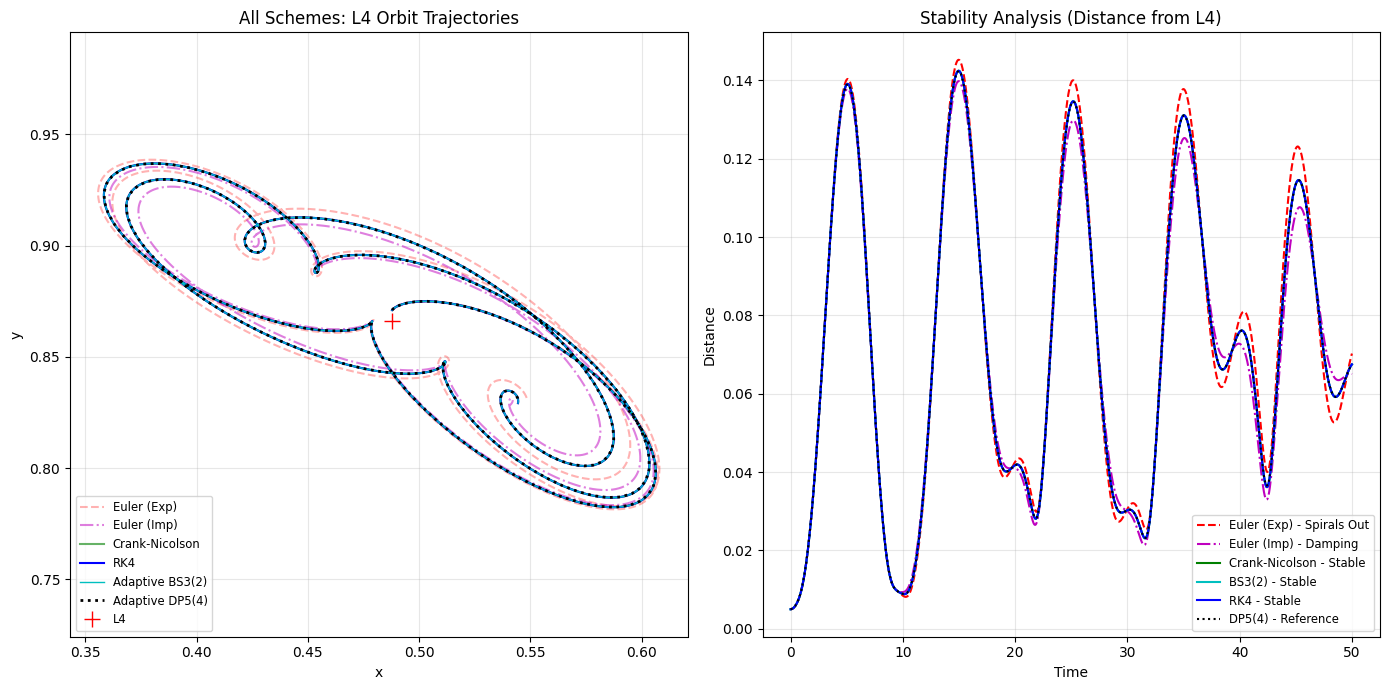

In [12]:
# --- Setup L4 Orbit ---
L4 = locations["L4"]
y0 = np.array(L4) + [0.0, 0.005, 0.0, 0.0] 
t_span = [0, 50] 
dt_fixed = 0.01

# ============================================
# 1. Fixed Step Schemes
# ============================================
# Wrapper to swap arguments (f(t,u) -> f(u,t)) for fixed-step solvers
dynamics_swapped = lambda u, t, **kwargs: cr3bp_equations(t, u, **kwargs)

# A. Explicit Euler (Order 1)
traj_euler, t_euler = schemes.integrate(
    schemes.euler_step, 
    y0, t_span[0], t_span[1], 
    dynamics_swapped, dt_fixed, mu=MU
)

# B. RK4 (Order 4)
traj_rk4, t_rk4 = schemes.integrate(
    schemes.rk4_step, 
    y0, t_span[0], t_span[1], 
    dynamics_swapped, dt_fixed, mu=MU
)

# C. Inverse Euler (Implicit, Order 1)
traj_inv_euler, t_inv_euler = schemes.integrate(
    schemes.inverse_euler_step, 
    y0, t_span[0], t_span[1], 
    dynamics_swapped, dt_fixed, mu=MU
)

# D. Crank-Nicolson (Implicit, Order 2)
traj_cn, t_cn = schemes.integrate(
    schemes.crank_nicolson_step, 
    y0, t_span[0], t_span[1], 
    dynamics_swapped, dt_fixed, mu=MU
)

# ============================================
# 2. Adaptive Schemes (Embedded RK)
# ============================================
# Wrapper for standard arguments (f(t,u)) for adaptive solvers
dynamics_standard = lambda t, u: cr3bp_equations(t, u, mu=MU)

# E. Dormand-Prince (Order 5/4) - High Precision
t_emb_dp, traj_emb_dp = schemes.solve_ode(
    dynamics_standard, 
    t_span, y0, 
    method="Dormand-Prince", 
    rtol=1e-8, atol=1e-8
)

# F. Bogacki-Shampine (Order 3/2) - Lower Precision
t_emb_bs, traj_emb_bs = schemes.solve_ode(
    dynamics_standard, 
    t_span, y0, 
    method="Bogacki-Shampine", 
    rtol=1e-8, atol=1e-8
)

# ============================================
# 3. Plotting
# ============================================
plt.figure(figsize=(14, 7))

# Plot 1: Trajectories
plt.subplot(1, 2, 1)
plt.plot(traj_euler[:,0], traj_euler[:,1], 'r--', label='Euler (Exp)', alpha=0.3)
plt.plot(traj_inv_euler[:,0], traj_inv_euler[:,1], 'm-.', label='Euler (Imp)', alpha=0.5)
plt.plot(traj_cn[:,0], traj_cn[:,1], 'g-', label='Crank-Nicolson', alpha=0.6)
plt.plot(traj_rk4[:,0], traj_rk4[:,1], 'b-', label='RK4', linewidth=1.5)
plt.plot(traj_emb_bs[:,0], traj_emb_bs[:,1], 'c-', label='Adaptive BS3(2)', linewidth=1)
plt.plot(traj_emb_dp[:,0], traj_emb_dp[:,1], 'k:', label='Adaptive DP5(4)', linewidth=2)

plt.plot(L4[0], L4[1], 'r+', markersize=12, label='L4')
plt.title("All Schemes: L4 Orbit Trajectories")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='lower left', fontsize='small')
plt.axis('equal')
plt.grid(True, alpha=0.3)

# Plot 2: Stability Analysis (Distance from L4)
plt.subplot(1, 2, 2)
# Calculate distances for all
d_eul = np.linalg.norm(traj_euler[:, :2] - L4[:2], axis=1)
d_inv = np.linalg.norm(traj_inv_euler[:, :2] - L4[:2], axis=1)
d_cn  = np.linalg.norm(traj_cn[:, :2] - L4[:2], axis=1)
d_rk4 = np.linalg.norm(traj_rk4[:, :2] - L4[:2], axis=1)
d_bs  = np.linalg.norm(traj_emb_bs[:, :2] - L4[:2], axis=1)
d_dp  = np.linalg.norm(traj_emb_dp[:, :2] - L4[:2], axis=1)

# Plotting
plt.plot(t_euler, d_eul, 'r--', label='Euler (Exp) - Spirals Out')
plt.plot(t_inv_euler, d_inv, 'm-.', label='Euler (Imp) - Damping')
plt.plot(t_cn, d_cn, 'g-', label='Crank-Nicolson - Stable')
plt.plot(t_emb_bs, d_bs, 'c-', label='BS3(2) - Stable')
plt.plot(t_rk4, d_rk4, 'b-', label='RK4 - Stable')
plt.plot(t_emb_dp, d_dp, 'k:', label='DP5(4) - Reference')

plt.title("Stability Analysis (Distance from L4)")
plt.xlabel("Time"); plt.ylabel("Distance")
plt.legend(fontsize='small')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

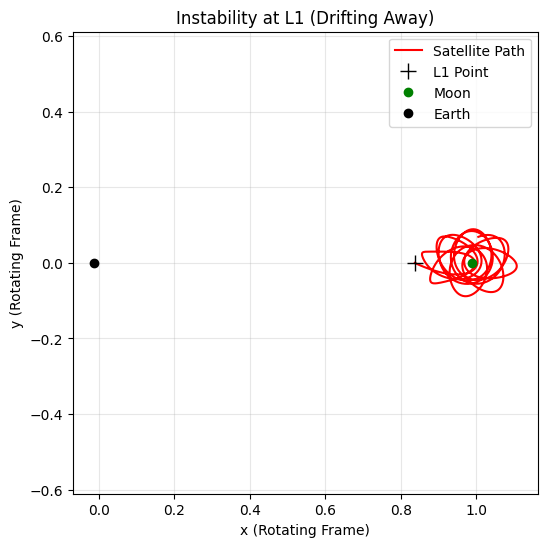

In [11]:
# ==========================================
# 4. Visualizing Instability at L1
# ==========================================

# 1. Setup Unstable Simulation
L1 = locations["L1"] 
y0_unstable = np.array(L1) + [1e-4, 0, 0, 0] 

# 2. Run Simulation using a Lambda
#Define the lambda inline. It must accept (t, u).
t_unstable, traj_unstable = schemes.solve_ode(
    lambda t, u: cr3bp_equations(t, u, mu=MU), 
    [0, 15],
    y0_unstable, 
    method="Dormand-Prince",
    rtol=1e-9, atol=1e-9
)

# 3. Plotting
plt.figure(figsize=(6, 6))
plt.plot(traj_unstable[:,0], traj_unstable[:,1], 'r-', label='Satellite Path')
plt.plot(L1[0], L1[1], 'k+', markersize=12, label='L1 Point')
plt.plot(1-MU, 0, 'go', label='Moon')
plt.plot(-MU, 0, 'ko', label='Earth')

plt.title("Instability at L1 (Drifting Away)")
plt.xlabel("x (Rotating Frame)")
plt.ylabel("y (Rotating Frame)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()